## Very Simple Markov Perfect Industry Dynamics

#### John Stachurski

In [1]:
import numpy as np
import quantecon as qe
from numba import njit
from lininterp import interp1d
import matplotlib.pyplot as plt

The state process is

$$ y_{t+1} = \rho y_t + b + \xi_{t+1} $$

where $-1 < \rho < 1$ and $\{ \xi_t \}$ is iid and uniform on $[-\sigma, \sigma]$


The parameters in this process are set to

In [21]:
ρ = 0.9
b = 4.0
σ = 1.0

Iterating on the bound $y_{t+1} \leq \rho y_t + b + \sigma$ yields

$$
    y_{t+1} \leq (b + \sigma) \frac{1 - \rho^{t+1}}{1 - \rho} + \rho^{t+1} y_0
$$

Taking the limit in this expression and then repeating the exercise with the reverse bound $y_{t+1} \geq \rho y_t + b - \sigma$, we find
that the stationary distribution for $y_t$ is supported on the interval

$$ I := \left[ \frac{b - \sigma}{1 - \rho}, \, \frac{b + \sigma}{1 - \rho} \right] $$

Let's set up a grid over $y$ values, covering the stationary distribution, which we can use to interpolate functions over:

In [22]:
y_min = (b - σ) / (1 - ρ)
y_max = (b + σ) / (1 - ρ)
y_grid_size = 10
y_grid = np.linspace(y_min, y_max, y_grid_size)

We'll use draws from the innovation $\xi$ to integrate via Monte Carlo:

In [23]:
mc_size = 100
ξ_draws = np.random.uniform(low=-σ, high=σ, size=mc_size)

The discount rate is

In [24]:
β = 0.9

Entry costs are increasing in the number of firms and decreasing in the state:

In [79]:
def ϕ(n, y):
    return np.exp(4.0 * n - 0.5 * y)

The profit function $\pi$ is decreasing in the number of firms and increasing in the exogenous state:

In [94]:
d = 1.0
γ = 2.0

def π(n, y):
    return d * y - n**γ

Set `n_max` to the first $n$ such that profits are negative for all possible values of $y_t$.

In [95]:
n_max = np.int(np.ceil((d * y_max**(1/γ))))
n_size = n_max + 1

In [96]:
n_max

8

In the text, `n_max` will be represented by $\bar n$.

First we solve for $v_E(\bar n, \cdot)$ as the fixed point of

$$ (Tf)(y) = 
   \max 
   \left\{
       0, \, \beta \, \mathbb E_y 
        [ \pi(\bar n, Y') + 
           f(Y')
        ]
   \right\}
$$
         

Next, for $n = \bar n -1, \bar n - 2, \ldots, 1$, we solve the family of contractions

$$ (T_n f)(y) = 
   \max 
   \left\{
       0, \, \beta  \, \mathbb E_y 
        [ \pi(n, Y') + 
           \mathbb 1\{\mu(n, Y') = n\} f(Y') +
           \mathbb 1\{\mu(n, Y') > n\} g_n(Y')
        ]
   \right\}
$$

Here

* $g_n(Y') := v_E(\mu(n, Y'), Y')$
* $\mu(n, y) := n + \sum_{m=n+1}^{\bar n} \mathbb 1\{v_E(m, y) > \phi(m, y)\}$ where $v_E(m, \cdot)$ is the fixed point of $T_m$

The expectations above will be approximated by Monte Carlo estimates of the form

$$
    \hat E_y [ h(Y')]
     := \frac{1}{m} \sum_{i=1}^m
         [ h( \rho y + b + \xi_i) ]
$$


In [97]:
def μ(n, y, v_E):
    μ_n = n
    if n < n_max:
        for m in range(n + 1, n_size):  
            if interp1d(y_grid, v_E[m, :], y) > ϕ(m, y):
                μ_n += 1
    return μ_n

In [98]:
def build_bellman_operator(v_E, n):
    
    def firm_bellman(f_in):
        # Set up
        def f(x):
            return interp1d(y_grid, f_in, x)
        f_out = np.empty_like(f_in)

        for i, y in enumerate(y_grid):
            t = 0.0
            for ξ in ξ_draws:
                yp = ρ * y + b + ξ
                t += π(n, yp) 
                μ_n = μ(n, yp, v_E)
                if μ_n == n:
                    t += f(yp)
                else:
                    t += interp1d(y_grid, v_E[μ_n, :], yp)
            f_out[i] = max(0, β * (t / mc_size))
        return f_out
    
    return firm_bellman


In [99]:
def iterate(operator, tol=0.0001, max_iter=500):
    error = tol + 1
    i = 0
    f_in = np.zeros(y_grid_size)
    while i < max_iter and error > tol:
        f_out = operator(f_in)
        error = np.max(np.abs(f_out - f_in))
        f_in = f_out
        i += 1
    print(f'i = {i}')
    return f_out

In [100]:
v_E = np.empty((n_size, y_grid_size))

In [101]:
n = n_max
while n >= 0:
    operator = build_bellman_operator(v_E, n)
    f_out = iterate(operator)
    v_E[n, :] = f_out
    n = n - 1

i = 1
i = 7
i = 101
i = 76
i = 15
i = 2
i = 2
i = 2
i = 2


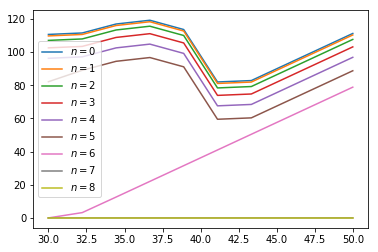

In [102]:
fig, ax = plt.subplots()
for n in range(n_size):
    ax.plot(y_grid, v_E[n, :], label=f'$n = {n}$')
ax.legend()
plt.show()

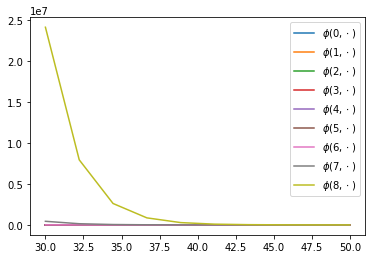

In [103]:
fig, ax = plt.subplots()
for n in range(n_size):
    ax.plot(y_grid, ϕ(n, y_grid), label=f'$\\phi({n}, \cdot)$')
ax.legend()
plt.show()

Next let's build $\alpha_E$

In [104]:
α_E = np.zeros((n_size, y_grid_size), dtype=np.int)
for n in range(n_size):
    for i, y in enumerate(y_grid):
        if interp1d(y_grid, v_E[n, :], y) > ϕ(n, y):
            α_E[n, i] = 1

In [105]:
α_E

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Now let's build $v_S$

In [106]:
v_S = np.empty((n_size, y_grid_size))
for n in range(n_size):
    for i, y in enumerate(y_grid):
        t = 0.0
        for ξ in ξ_draws:
            yp = ρ * y + b + ξ
            t += π(n, yp) + interp1d(y_grid, v_E[μ(n, y, v_E), :], yp)
        v_S[n, i] = t / mc_size

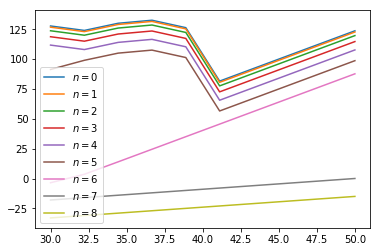

In [107]:
fig, ax = plt.subplots()
for n in range(n_size):
    ax.plot(y_grid, v_S[n, :], label=f'$n = {n}$')
ax.legend()
plt.show()